# Here, we're gonna start playing around with SMOTE. It's basically a technique for balancing data that isn't well represented from unbalanced datasets. I'm gonna be following [this](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/) tutorial

Using the ["imbalanced-learn"](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTE.html) package alongside regular sklearn modules.

In [1]:
# basic checking version number of the package
import imblearn
print(imblearn.__version__)

0.10.1


First off, for testing purposes, we can use `make_classification()` from the sklearn library to create a synthetic binary classification dataset with 10,000 examples and a 1:100 class distribution (as per the tutorial):

In [18]:
# importing make_classification from sklearn library
from sklearn.datasets import make_classification

In [5]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

Using the `Counter` object, we can summarize the number of examples in each class to validate the dataset.

In [6]:
# import Counter for use below
from collections import Counter

In [7]:
# summarize class distribution
counter = Counter(y)
print(counter)

Counter({0: 9900, 1: 100})


Now we create a scatter plot of the dataset, coloring examples of each class with a different color to see clearly the spatial nature of the imbalance 

In [8]:
# importing pyplot
import matplotlib.pyplot as pyplot
# importing numpy (for "where()"
import numpy as np

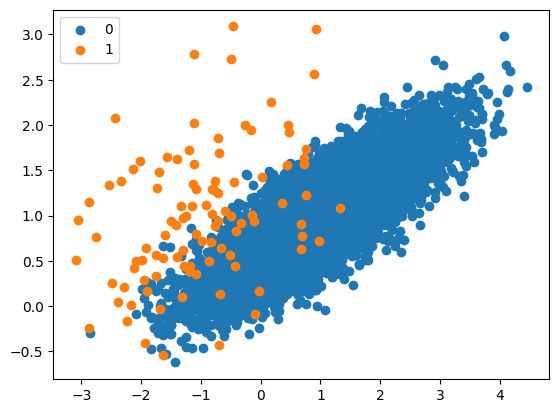

In [9]:
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

Nice! This scatter plot demonstrates the dataset as a large mass of points which belong to the majority class (blue) and minority class (orange). Notice the overlap between the classes.

Following this, we will oversample the minority class using SMOTE, then plot the transformed dataset.
The SMOTE implementation used here will be from the `imbalanced-learn` Python library, in the SMOTE class.

According to the tutorial I'm following, the SMOTE class here is reminiscent of a data transform object from sklearn, in how it needs to be defined and configured, fit on a dataset, and be applied to create new transformed versions of said dataset.
In the following example, we will define a SMOTE instance with default parameters to balance the minority class, then fir and apply it in one stp in order to derive a transformed version of our dataset from it.

In [10]:
# import SMOTE
from imblearn.over_sampling import SMOTE

In [11]:
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

We can use this to create a scatter plot from the new data, too. We would expect to see lots of new examples of the minority class on lines between the original examples in the minority class, according to the tutorial.

Now, we will summarize the new class distribution, which should demonstrate a balanced distribution.

In [12]:
# summarize the new class distribution
counter = Counter(y)
print(counter)

Counter({0: 9900, 1: 9900})


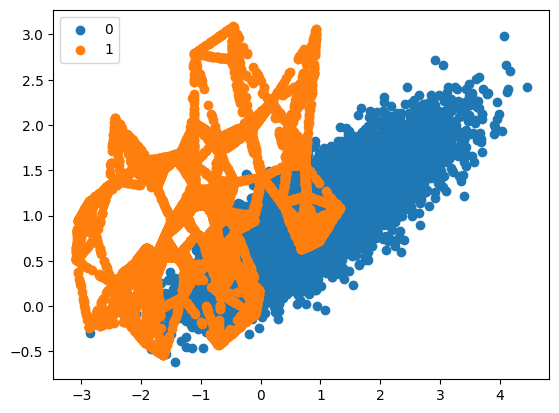

In [13]:
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

Since the original minority class had so few examples relative to the majority class, the lines between the minority samples which have been added appear very distinct here.

According to the text, the original paper on SMOTE suggested to combine it with random undersampling of the majority class, in order to help make it a more uniform distribution.

The `imbalanced-learn` library supports random undersampling via the `RandomUnderSampler` class, which should help out here.

Using these techniques, we can update the example by doing a few things. First, we will oversample the minority class to have only 10 percent the number of examples of the majority class (as opposed to 100%). Then, we will use random undersampling to reduce the number of examples in the majority class to have about 50% more than the minority class. (in this example, the minority class should end up with about 1000 samples, and the majority class about 2000).

In order to carry this out, we can pass our desired ratios as arguments to `SMOTE` and `RandomUnderSampler`, as follows.

In [14]:
# importing the RandomUnderSampler class from imblearn
from imblearn.under_sampling import RandomUnderSampler

In [15]:
# redefining X and y for this new example dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# summarize new class distribution
counter = Counter(y)
print(counter)

Counter({0: 9900, 1: 100})


In [16]:
# over sampling via SMOTE
over = SMOTE(sampling_strategy=0.1)
# under sampling via RandomUnderSample
under = RandomUnderSampler(sampling_strategy=0.5)

These two transforms can be chained together into a `Pipeline` as follows.

In [20]:
# import Pipeline from imblearn
from imblearn.pipeline import Pipeline

In [21]:
# pipelining "over" and "under"
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

This `Pipeline` can be applied to a dataset, so as to carry out each transformation and return a final dataset composed of the aggregation of each of the applied transforms. In this case, the applied transforms will be `over` (oversampling of the minority class) followed by `under` (undersampling of the majority class).

Now, the pipeline can be fit and applied to the dataset just as a single transform would.

In [22]:
# transform the dataset
X, y = pipeline.fit_resample(X, y)

With this, the dataset has been transformed; first via oversampling the minority class, then by undersampling the majority class. A summary of the final class distribution can be done as follows.

In [23]:
# summarize the new class distribution
counter = Counter(y)
print(counter)

Counter({0: 1980, 1: 990})


As we can see here, the final class distribution (after the recent sequence of transforms) matches what we had hoped; a 1:2 ratio, with about 2000 in the majority class and 1000 in the minority class.
A scatter plot will help us further visualize the results.

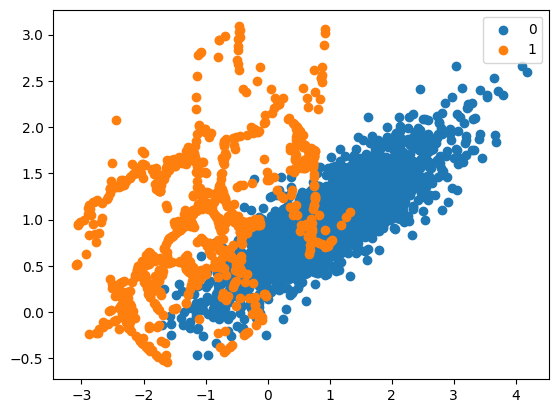

In [24]:
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

## Now that we have a better understanding of the basics of SMOTE, we will look a little deeper into its application to `classification` (which will be beneficial for the future uses of SMOTE in this project)

This part of the [tutorial](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/) will be looking at using SMOTE as a data preparation method for fitting and evaluating machine learning algorithms in scikit-learn (e.g. the sklearn library).

We will be using the binary classification dataset from the previous section then fit and evaluate a decision tree algorithm.

The algorithm we will be using is defined with any required hyperparameters (in this case we will use the defaults); then, we will use repeated stratified [k-fold cross-validation](https://machinelearningmastery.com/k-fold-cross-validation/) to evaluate the model. 
In this case, we'll be using three repeats of 10-fold cross-validation. This means that 10-fold cross-validation will be applied three times fitting and evaluating 30 models on the dataset.

Our dataset is stratified, which means that each fold of the cross-validation split will have the same class distribution as the original dataset (in our case, a 1:100 ratio).
The model will be evaluated using the [ROC area under curve (AUC) metric](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/). According to the tutorial, this can be "optimistic" for severely imbalanced datasets, but will still show a relative change/difference when used with better performing models.

In [28]:
# import DecisionTreeClassifier from sklearn library
from sklearn.tree import DecisionTreeClassifier
# import RepeatedStratifiedKFold from sklearn library
from sklearn.model_selection import RepeatedStratifiedKFold
# import cross_val_score from sklearn library
from sklearn.model_selection import cross_val_score

In [34]:
# redefine X and y for purposes of this example
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

In [41]:
# define model
model = DecisionTreeClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

Now that it's fit, we can calculate and report the mean of the scores across the folds and repeats.

In [43]:
# report mean scores across the folds and repeats
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.768


According to the text, we wouldn't expect a decision tree fit on the raw imbalanced dataset to perform very well, which is likely important to note. 
Something else of note is that, due to the stochastic nature of the algorithm/evaluation procedure and/or differences in numerical precision, [results may vary](https://machinelearningmastery.com/different-results-each-time-in-machine-learning/). In this case, our mean ROC AUC was 0.768, but in the case of the tutorial, their results indicated a mean ROC AUC of 0.761.

Now we're going to try the same model and evaluation method, but with a SMOTE transformed version of the dataset.

For applying this oversampling technique during k-fold cross-validation, the alleged correct way to do it is to apply the method to *only the training dataset*, and then evaluate the model on a stratified, but non-transformed test set.

This can be done by using a `Pipeline` which first transforms the dataset with SMOTE and *then* fits the model, as follows.

In [44]:
# define pipeline
steps = [('over', SMOTE()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)

And now, this pipeline can be evaluated using repeated k-fold cross-validation.

In [47]:
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.819


As noted earlier, results may vary, due to the stochastic nature of the model being demonstrated. In our case, the mean ROC AUC was 0.819; in the tutorial, they got 0.809. 

As is demonstrated with the difference in mean ROC AUC, utilizing SMOTE has appeared to improve the performance (according to the ROC AUC metric) by a noticeable margin.

According to the tutorial, the [paper](https://arxiv.org/pdf/1106.1813.pdf) mentions that the current understanding is that SMOTE performs better when combined with undersampling of the majority class (e.g. random undersampling.

To implement this, we will simply use the same technique as used in the prior example scenario, the `RandomUnderSampler` from imblearn.

In [48]:
# new pipeline definition
model = DecisionTreeClassifier()
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

As in the prior example scenario, we have put things together so as to devise an approximate 1:2 ratio between the number of samples from the minority class and majority class (respectively). This was done by oversampling the minority class with SMOTE to about a 1:10 ratio, then undersampling the majority class to fit with the number of oversamples (approximately 1000 samples) in order to produce a 1:2 sample ratio (as in the prior scenario). 